In [20]:
import numpy as np
import pylab
import networkx as nx

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

In [18]:
def generate_random_graph(num_nodes):
    nums = np.ones(num_nodes**2)
    nums[:int(len(nums)/2)] = 0
    np.random.shuffle(nums)
    nums = np.reshape(nums, (num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                nums[i, j] = 0
    return nums

In [21]:
nums = generate_random_graph(num_nodes = 10)
G = nx.from_numpy_matrix(nums)

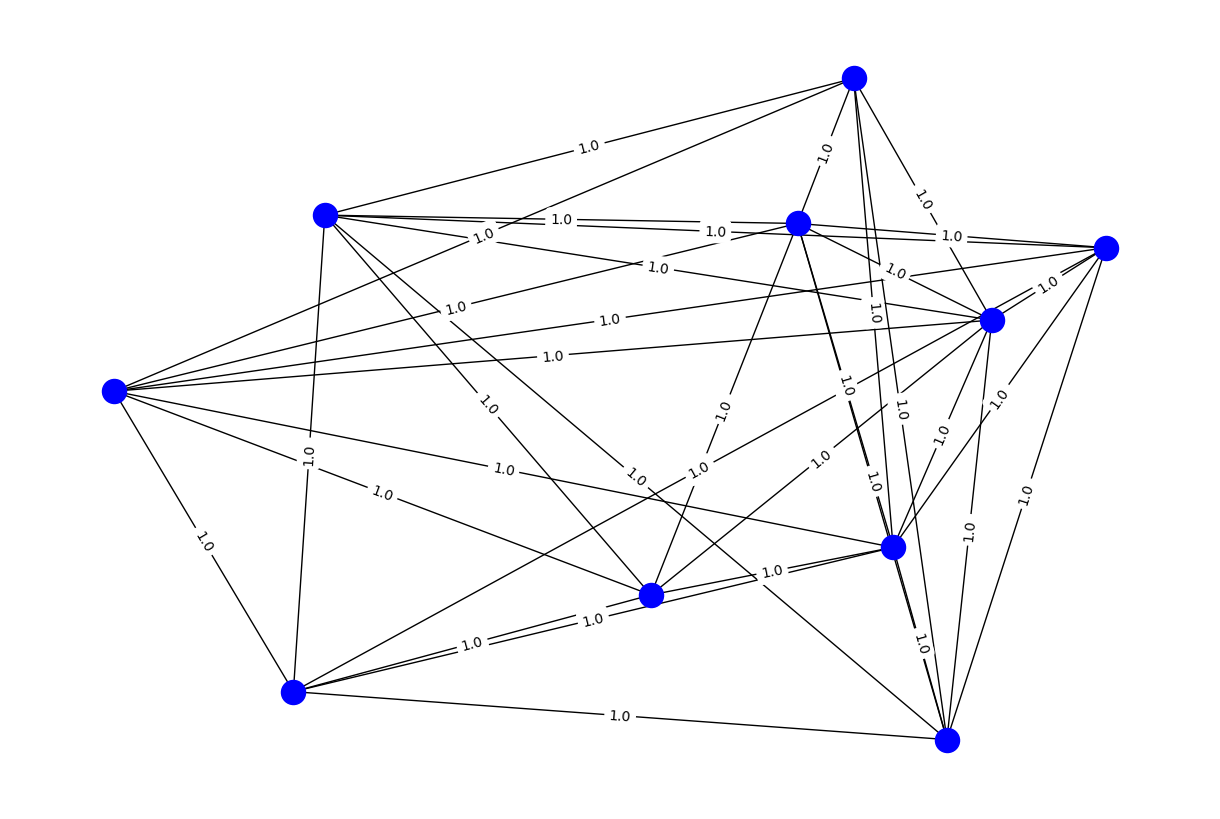

In [22]:
layout = nx.random_layout(G, seed=10)
nx.draw(G, layout, node_color='blue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);
plt.show()

In [67]:
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliSumOp

def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 separate the vertices into two set of the same size
            2 make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        PauliSumOp: operator for the Hamiltonian
        float: a constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([-0.5, Pauli((z_p, x_p))])
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([1, Pauli((z_p, x_p))])
            else:
                shift += 1

    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    return PauliSumOp.from_list(pauli_list), shift

qubit_op, offset = get_operator(nums)

In [70]:
from qiskit import QuantumCircuit
from qiskit.opflow import OperatorBase
from qiskit.circuit.library import QAOAAnsatz

ansatz = QAOAAnsatz(qubit_op, reps=1)
ansatz.draw()

┌────────────────────────────┐
q_0: ┤0                           ├
     │                            │
q_1: ┤1                           ├
     │                            │
q_2: ┤2                           ├
     │                            │
q_3: ┤3                           ├
     │                            │
q_4: ┤4                           ├
     │  QAOA(t[0],t[1],t[2],t[3]) │
q_5: ┤5                           ├
     │                            │
q_6: ┤6                           ├
     │                            │
q_7: ┤7                           ├
     │                            │
q_8: ┤8                           ├
     │                            │
q_9: ┤9                           ├
     └────────────────────────────┘

H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

In [73]:
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = QAOA(optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')), reps=2)
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


In [77]:
vqe.ansatz.parameters

ParameterView([ParameterVectorElement(t[0]), ParameterVectorElement(t[1]), ParameterVectorElement(t[2]), ParameterVectorElement(t[3])])

In [74]:
vqe.ansatz.draw()

┌───┐                                                         »
q_0: ┤ H ├─────────────────────────────────────────────────────────»
     ├───┤                                                         »
q_1: ┤ H ├─────────────────────────────────────────────────────────»
     ├───┤                                                         »
q_2: ┤ H ├─────────────────────────────────────────────────────────»
     ├───┤                                                         »
q_3: ┤ H ├─────────────────────────────────────────────────────────»
     ├───┤                                                         »
q_4: ┤ H ├─────────────────────────────────────────────────────────»
     ├───┤                                                         »
q_5: ┤ H ├─────────────────────────────────────────────────────────»
     ├───┤                                                    ┌───┐»
q_6: ┤ H ├────────────────────────────────────────────────────┤ X ├»
     ├───┤                          ┌───┐┌──────────────┐┌───┐└─┬─┘»
q_7: ┤ H ├──────────────────────────┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├──┼──»
     ├───┤┌───┐┌──────────────┐┌───┐└─┬─┘└──────────────┘└─┬─┘  │  »
q_8: ┤ H ├┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├──┼────────────────────┼────┼──»
     ├───┤└─┬─┘└──────────────┘└─┬─┘  │                    │    │  »
q_9: ┤ H ├──■────────────────────■────■────────────────────■────■──»
     └───┘                                                         »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_1: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_2: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_3: ─────────────────────────────────────────────────────────────────────────»
«                                                    ┌───┐┌──────────────┐┌───┐»
«q_4: ───────────────────────────────────────────────┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├»
«                          ┌───┐┌──────────────┐┌───┐└─┬─┘└──────────────┘└─┬─┘»
«q_5: ─────────────────────┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├──┼────────────────────┼──»
«     ┌──────────────┐┌───┐└─┬─┘└──────────────┘└─┬─┘  │                    │  »
«q_6: ┤ Rz(2.0*t[0]) ├┤ X ├──┼────────────────────┼────┼────────────────────┼──»
«     └──────────────┘└─┬─┘  │                    │    │                    │  »
«q_7: ──────────────────┼────┼────────────────────┼────┼────────────────────┼──»
«                       │    │                    │    │                    │  »
«q_8: ──────────────────┼────┼────────────────────┼────┼────────────────────┼──»
«                       │    │                    │    │                    │  »
«q_9: ──────────────────■────■────────────────────■────■────────────────────■──»
«                                                                              »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«                                                         ┌───┐┌──────────────┐»
«q_1: ────────────────────────────────────────────────────┤ X ├┤ Rz(2.0*t[0]) ├»
«                               ┌───┐┌──────────────┐┌───┐└─┬─┘└──────────────┘»
«q_2: ──────────────────────────┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├──┼──────────────────»
«     ┌───┐┌──────────────┐┌───┐└─┬─┘└──────────────┘└─┬─┘  │                  »
«q_3: ┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├──┼────────────────────┼────┼──────────────────»
«     └─┬─┘└──────────────┘└─┬─┘  │                    │    │                  »
«q_4: ──┼────────────────────┼────┼────────────────────┼────┼──────────────────»
«       │                    │    │          

In [ ]:
def fun(theta):
    alphas = theta[0]
    betas = theta[1]
    
    qc = QAOA(optimizer, callback=store_intermediate_result, 
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator'))).ansatz
    
    
    

In [28]:
pylab.rcParams['figure.figsize'] = (6, 6)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

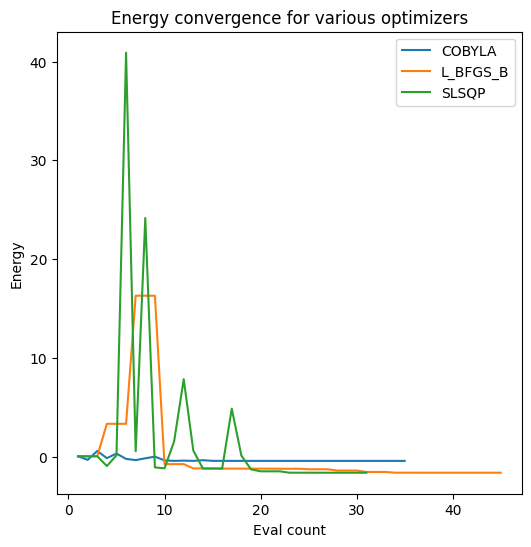

In [29]:
import matplotlib.pyplot as plt
plt.show()

In [31]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -13.50000


In [35]:
pylab.rcParams['figure.figsize'] = (6, 6)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

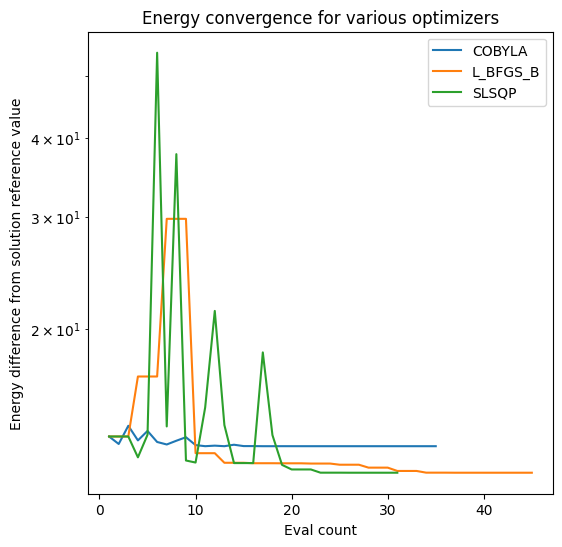

In [36]:
plt.show()

In [37]:
from qiskit.opflow.gradients import Gradient

algorithm_globals.random_seed = 50
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

optimizer = SLSQP(maxiter=60)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = QAOA(optimizer, callback=store_intermediate_result,
          gradient=Gradient(grad_method='fin_diff'),
          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
print(f'Value using Gradient: {result.eigenvalue.real:.5f}')

KeyboardInterrupt: 

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence using Gradient')
pylab.legend(loc='upper right');
plt.show()